In [1]:
## Author: Kutsal Baran Özkurt ##
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from albumentations import *
from skimage.transform import resize

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model

import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
SHAPE = (224, 224, 3)
BATCH_SIZE = 24
EPOCHS = 100
N_SPLITS = 5
SEED = 1881
TRAIN_TEST_RATIO = 0.2

BASE_DIR     = "../../data/BreaKHis_v1/histology_slides/breast/"
DATASET_MODE = ["40X", "100X", "200X", "400X"]

In [3]:
class BREAKHIST_DATASET:
    
    """
    input_shape           --> TUPLE.wanted image size
    batch_size            --> INT.yielding data size for every iteration
    orders                --> LIST.which images will be used. max=len(all_images). it can be used for K-fold(CV).
    base_dir              --> STR.the DIR which is include "benign" and "malignant" dirs.
    dataset_mode          --> STR. Which type of images will be used: "40X", "100X", "200X", "400X".
    seed                  --> INT. This allow to dataset generator to more reproduciable and it ensures that x and y are shuffled with compatible.
    augment               --> BOOL. Augment data or not.
    train_test_ratio      --> How much of data will be used as test set.
    ---------
    GENERAL_CLASSES       --> LIST.["benign", "malignant"]
    BENIGN_SUB_CLASSES    --> LIST.["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
    MALIGNANT_SUB_CLASSES --> LIST.["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
    """
    
    def __init__(self, input_shape, batch_size, orders, base_dir, dataset_mode, seed, train_test_ratio, augment=True):
        self.SHAPE                 = input_shape
        self.BATCH_SIZE            = batch_size
        self.arr                   = orders
        self.DATASET_MODE          = dataset_mode
        self.SEED                  = seed
        self.TT_RATIO              = train_test_ratio
        self.AUG                   = augment
        
        self.BASE_DIR              = base_dir
        self.GENERAL_CLASSES       = ["benign", "malignant"]
        self.BENIGN_SUB_CLASSES    = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
        self.MALIGNANT_SUB_CLASSES = ["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
        
        
    def get_paths_n_labels(self):

        x     = []
        label = []
        
        for data_mode in self.DATASET_MODE:
            for ix2, b in enumerate(self.MALIGNANT_SUB_CLASSES):
                path1 = self.BASE_DIR+"malignant"+"/SOB/"+b
                for c in os.listdir(path1):
                    path2 = path1+"/"+c+"/"+data_mode
                    for img_name in os.listdir(path2):
                        path3 = path2+"/"+img_name
                        
                        # x
                        img_path = path3 

                        # y
                        main_targets = np.zeros((4), dtype=np.float32) # ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
                        for ix, benign_class in enumerate(self.MALIGNANT_SUB_CLASSES):
                            if benign_class in img_path:
                                main_targets[ix] = 1.
                                
                      
                        # Store the values
                        x.append(img_path)
                        label.append(main_targets)
        
        return x, label
    
    def __len__(self):
        return len(self.get_paths_n_labels()[0])
    
    def get_img(self, img_path):
        img = Image.open(img_path)
        return np.array(img)
    
    def augmenting(self, img):
        if self.AUG:
            augment = Compose([VerticalFlip(p=0.5),
                               HorizontalFlip(p=0.5),
                               RandomBrightnessContrast(p=0.3),
                               ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0.2, rotate_limit=20)])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    
    def resize_and_normalize(self, img):
        img = resize(img, self.SHAPE)
        return img
    
    def get_shuffled_data(self):
        img_paths, labels = self.get_paths_n_labels()

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
        
    def split_train_test(self, get):  # get=={"train","test"}
        img_paths, labels = self.get_shuffled_data()
        x_train, x_test, y_train, y_test = train_test_split(img_paths, labels, test_size=self.TT_RATIO, random_state=self.SEED)
        
        if get=='train':
            return x_train, y_train
        
        elif get=='test':
            return x_test, y_test
    
    def data_generator(self):
        img_paths, labels = self.split_train_test(get="train")
        
        while True:
            x = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y = np.empty((self.BATCH_SIZE, 4), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                # x
                img_path = img_paths[id_]
                img = self.get_img(img_path)
                img = self.augmenting(img)
                img = self.resize_and_normalize(img)
                  
                # y 
                label = labels[id_]
             
                # Store the values    
                x[ix] = img
                y[ix] = label

            yield x, y

[[[[0.61185    0.22499125 0.541798  ]
   [0.6781294  0.23310356 0.594761  ]
   [0.5666623  0.15437675 0.51374084]
   ...
   [0.59760594 0.13600096 0.5405528 ]
   [0.6782716  0.17700674 0.58106834]
   [0.61219144 0.16858806 0.49453124]]

  [[0.59296435 0.20570947 0.51614803]
   [0.6826593  0.21984419 0.5541929 ]
   [0.61266196 0.17483369 0.5369376 ]
   ...
   [0.67196035 0.17461047 0.5615043 ]
   [0.6935924  0.18873861 0.5736695 ]
   [0.63182557 0.18539041 0.5041623 ]]

  [[0.65337664 0.25729385 0.5617603 ]
   [0.72427344 0.25542498 0.575081  ]
   [0.6421919  0.1935443  0.5611498 ]
   ...
   [0.68005735 0.17557554 0.5611498 ]
   [0.6917914  0.18303572 0.55841213]
   [0.6477504  0.18456976 0.49752495]]

  ...

  [[0.6329154  0.23448442 0.60895044]
   [0.54650295 0.10038953 0.46218926]
   [0.44462973 0.05874694 0.41182816]
   ...
   [0.62879026 0.16927302 0.61947656]
   [0.6831364  0.21288954 0.65183604]
   [0.67350537 0.24568452 0.5960544 ]]

  [[0.48288253 0.11873687 0.45983675]
   [0.4

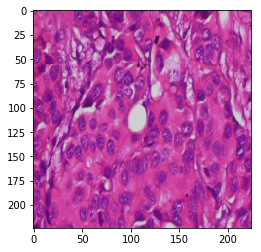

In [4]:
dataset = BREAKHIST_DATASET(SHAPE, 1, range(1), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)

for ix, data in enumerate(dataset.data_generator()):
    img, y = data
    print(img)
    print(img.shape)
    print("-"*10)
    print(y)
    print(y.shape)
    print("-"*10)
    print(img[0,:,:,:].shape)
    plt.imshow(img[0,:,:,:])
    plt.show()
    
    if ix==0:
        break

In [5]:
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [6]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [7]:
# copied from https://github.com/kobiso/CBAM-keras/blob/master/models/attention_module.py
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._keras_shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [8]:
# copied from https://gist.github.com/mjdietzx/5319e42637ed7ef095d430cb5c5e8c64
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [9]:
def create_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(4, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [10]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

global_average_pooling2d_2 (Glo (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, 1, 128)    0           global_average_pooling2d_2[0][0] 
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 1, 128)    0           global_max_pooling2d_2[0][0]     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 1, 16)     2064        reshape_3[0][0]                  
                                                                 reshape_4[0][0]                  
__________

In [11]:
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

for ix, (train_index, test_index) in enumerate(kf.split(range(len(dataset.split_train_test("train")[0])))):
                                               
    tg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, train_index, BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)
    vg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, test_index , BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False)
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.9,
                             cycle_length=10,
                             mult_factor=2.)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=[precision, recall, f1, 'acc'])

    model_ckpt = "BREAKHIST_FOLD_"+str(ix)+".h5"
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir='./log_'+str(ix), update_freq='epoch'), 
                 schedule] 
                                               
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index)//BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(test_index)//BATCH_SIZE,
                        callbacks=callbacks)


Epoch 1/100
 - 146s - loss: 0.9505 - precision: 0.7002 - recall: 0.5402 - f1: 0.6075 - acc: 0.6372 - val_loss: 3.5408 - val_precision: 0.6551 - val_recall: 0.6551 - val_f1: 0.6551 - val_acc: 0.6551

Epoch 00001: val_loss improved from inf to 3.54080, saving model to BREAKHIST_FOLD_0.h5
Epoch 2/100
 - 110s - loss: 0.8558 - precision: 0.7342 - recall: 0.6013 - f1: 0.6600 - acc: 0.6759 - val_loss: 2.1046 - val_precision: 0.3623 - val_recall: 0.3137 - val_f1: 0.3356 - val_acc: 0.3380

Epoch 00002: val_loss improved from 3.54080 to 2.10462, saving model to BREAKHIST_FOLD_0.h5
Epoch 3/100
 - 104s - loss: 0.8190 - precision: 0.7314 - recall: 0.6085 - f1: 0.6632 - acc: 0.6823 - val_loss: 1.1188 - val_precision: 0.6409 - val_recall: 0.5347 - val_f1: 0.5821 - val_acc: 0.6169

Epoch 00003: val_loss improved from 2.10462 to 1.11881, saving model to BREAKHIST_FOLD_0.h5
Epoch 4/100
 - 98s - loss: 0.8188 - precision: 0.7230 - recall: 0.6172 - f1: 0.6650 - acc: 0.6736 - val_loss: 1.5884 - val_precisio


Epoch 00032: val_loss did not improve from 0.41403
Epoch 33/100
 - 98s - loss: 0.4865 - precision: 0.8266 - recall: 0.7737 - f1: 0.7988 - acc: 0.8024 - val_loss: 1.1818 - val_precision: 0.6924 - val_recall: 0.6655 - val_f1: 0.6782 - val_acc: 0.6817

Epoch 00033: val_loss did not improve from 0.41403
Epoch 34/100
 - 99s - loss: 0.5085 - precision: 0.8166 - recall: 0.7624 - f1: 0.7882 - acc: 0.7937 - val_loss: 0.4798 - val_precision: 0.8279 - val_recall: 0.7569 - val_f1: 0.7897 - val_acc: 0.8021

Epoch 00034: val_loss did not improve from 0.41403
Epoch 35/100
 - 98s - loss: 0.4405 - precision: 0.8480 - recall: 0.7975 - f1: 0.8215 - acc: 0.8229 - val_loss: 0.5089 - val_precision: 0.8126 - val_recall: 0.7859 - val_f1: 0.7988 - val_acc: 0.7975

Epoch 00035: val_loss did not improve from 0.41403
Epoch 36/100
 - 98s - loss: 0.4871 - precision: 0.8306 - recall: 0.7758 - f1: 0.8017 - acc: 0.8032 - val_loss: 1.6559 - val_precision: 0.6225 - val_recall: 0.6134 - val_f1: 0.6179 - val_acc: 0.6134



Epoch 00065: val_loss improved from 0.26418 to 0.23929, saving model to BREAKHIST_FOLD_0.h5
Epoch 66/100
 - 97s - loss: 0.3497 - precision: 0.8788 - recall: 0.8545 - f1: 0.8663 - acc: 0.8649 - val_loss: 1.1525 - val_precision: 0.6290 - val_recall: 0.5394 - val_f1: 0.5799 - val_acc: 0.5961

Epoch 00066: val_loss did not improve from 0.23929
Epoch 67/100
 - 96s - loss: 0.3851 - precision: 0.8676 - recall: 0.8397 - f1: 0.8532 - acc: 0.8559 - val_loss: 0.4124 - val_precision: 0.8302 - val_recall: 0.8113 - val_f1: 0.8206 - val_acc: 0.8171

Epoch 00067: val_loss did not improve from 0.23929
Epoch 68/100
 - 96s - loss: 0.3140 - precision: 0.8808 - recall: 0.8617 - f1: 0.8710 - acc: 0.8718 - val_loss: 0.2840 - val_precision: 0.9011 - val_recall: 0.8831 - val_f1: 0.8918 - val_acc: 0.8924

Epoch 00068: val_loss did not improve from 0.23929
Epoch 69/100
 - 96s - loss: 0.3676 - precision: 0.8673 - recall: 0.8411 - f1: 0.8538 - acc: 0.8556 - val_loss: 0.4795 - val_precision: 0.7950 - val_recall: 0


Epoch 00029: val_loss improved from 0.22517 to 0.19862, saving model to BREAKHIST_FOLD_1.h5
Epoch 30/100
 - 99s - loss: 0.3121 - precision: 0.8892 - recall: 0.8689 - f1: 0.8787 - acc: 0.8793 - val_loss: 0.2112 - val_precision: 0.9006 - val_recall: 0.8924 - val_f1: 0.8964 - val_acc: 0.8993

Epoch 00030: val_loss did not improve from 0.19862
Epoch 31/100
 - 99s - loss: 0.2915 - precision: 0.8885 - recall: 0.8704 - f1: 0.8792 - acc: 0.8793 - val_loss: 0.3014 - val_precision: 0.8937 - val_recall: 0.8843 - val_f1: 0.8888 - val_acc: 0.8843

Epoch 00031: val_loss did not improve from 0.19862
Epoch 32/100
 - 98s - loss: 0.2694 - precision: 0.9032 - recall: 0.8880 - f1: 0.8954 - acc: 0.8938 - val_loss: 0.1949 - val_precision: 0.9237 - val_recall: 0.9097 - val_f1: 0.9165 - val_acc: 0.9201

Epoch 00032: val_loss improved from 0.19862 to 0.19491, saving model to BREAKHIST_FOLD_1.h5
Epoch 33/100
 - 99s - loss: 0.3079 - precision: 0.8817 - recall: 0.8655 - f1: 0.8733 - acc: 0.8738 - val_loss: 0.490


Epoch 00061: val_loss did not improve from 0.14146
Epoch 62/100
 - 98s - loss: 0.2289 - precision: 0.9151 - recall: 0.8999 - f1: 0.9072 - acc: 0.9094 - val_loss: 0.1874 - val_precision: 0.9240 - val_recall: 0.9167 - val_f1: 0.9202 - val_acc: 0.9225

Epoch 00062: val_loss did not improve from 0.14146
Epoch 63/100
 - 98s - loss: 0.2336 - precision: 0.9065 - recall: 0.8921 - f1: 0.8991 - acc: 0.8999 - val_loss: 0.3977 - val_precision: 0.8722 - val_recall: 0.8692 - val_f1: 0.8707 - val_acc: 0.8704

Epoch 00063: val_loss did not improve from 0.14146
Epoch 64/100
 - 98s - loss: 0.2806 - precision: 0.8966 - recall: 0.8805 - f1: 0.8883 - acc: 0.8895 - val_loss: 0.5503 - val_precision: 0.8368 - val_recall: 0.8079 - val_f1: 0.8218 - val_acc: 0.8194

Epoch 00064: val_loss did not improve from 0.14146
Epoch 65/100
 - 98s - loss: 0.2403 - precision: 0.9079 - recall: 0.8889 - f1: 0.8981 - acc: 0.8999 - val_loss: 0.1541 - val_precision: 0.9431 - val_recall: 0.9363 - val_f1: 0.9396 - val_acc: 0.9387



Epoch 00026: val_loss did not improve from 0.15545
Epoch 27/100
 - 96s - loss: 0.2193 - precision: 0.9142 - recall: 0.9031 - f1: 0.9085 - acc: 0.9097 - val_loss: 0.3210 - val_precision: 0.8954 - val_recall: 0.8704 - val_f1: 0.8825 - val_acc: 0.8773

Epoch 00027: val_loss did not improve from 0.15545
Epoch 28/100
 - 96s - loss: 0.2038 - precision: 0.9257 - recall: 0.9152 - f1: 0.9203 - acc: 0.9213 - val_loss: 1.3850 - val_precision: 0.7168 - val_recall: 0.7130 - val_f1: 0.7149 - val_acc: 0.7130

Epoch 00028: val_loss did not improve from 0.15545
Epoch 29/100
 - 98s - loss: 0.2298 - precision: 0.9177 - recall: 0.9013 - f1: 0.9093 - acc: 0.9103 - val_loss: 0.1351 - val_precision: 0.9406 - val_recall: 0.9363 - val_f1: 0.9384 - val_acc: 0.9363

Epoch 00029: val_loss improved from 0.15545 to 0.13511, saving model to BREAKHIST_FOLD_2.h5
Epoch 30/100
 - 98s - loss: 0.2228 - precision: 0.9228 - recall: 0.9077 - f1: 0.9150 - acc: 0.9138 - val_loss: 0.2663 - val_precision: 0.8796 - val_recall: 0


Epoch 00059: val_loss did not improve from 0.11363
Epoch 60/100
 - 97s - loss: 0.1688 - precision: 0.9344 - recall: 0.9280 - f1: 0.9311 - acc: 0.9323 - val_loss: 0.2424 - val_precision: 0.9055 - val_recall: 0.8993 - val_f1: 0.9023 - val_acc: 0.9062

Epoch 00060: val_loss did not improve from 0.11363
Epoch 61/100
 - 96s - loss: 0.2033 - precision: 0.9236 - recall: 0.9117 - f1: 0.9175 - acc: 0.9167 - val_loss: 1.3712 - val_precision: 0.7148 - val_recall: 0.7095 - val_f1: 0.7121 - val_acc: 0.7118

Epoch 00061: val_loss did not improve from 0.11363
Epoch 62/100
 - 96s - loss: 0.1908 - precision: 0.9287 - recall: 0.9135 - f1: 0.9209 - acc: 0.9225 - val_loss: 0.1211 - val_precision: 0.9374 - val_recall: 0.9363 - val_f1: 0.9369 - val_acc: 0.9375

Epoch 00062: val_loss did not improve from 0.11363
Epoch 63/100
 - 96s - loss: 0.1771 - precision: 0.9339 - recall: 0.9248 - f1: 0.9292 - acc: 0.9285 - val_loss: 0.4803 - val_precision: 0.8280 - val_recall: 0.8183 - val_f1: 0.8230 - val_acc: 0.8275



Epoch 00092: val_loss did not improve from 0.09187
Epoch 93/100
 - 99s - loss: 0.1782 - precision: 0.9343 - recall: 0.9242 - f1: 0.9291 - acc: 0.9285 - val_loss: 0.4514 - val_precision: 0.8390 - val_recall: 0.8322 - val_f1: 0.8355 - val_acc: 0.8368

Epoch 00093: val_loss did not improve from 0.09187
Epoch 94/100
 - 98s - loss: 0.1709 - precision: 0.9366 - recall: 0.9262 - f1: 0.9313 - acc: 0.9329 - val_loss: 0.1627 - val_precision: 0.9339 - val_recall: 0.9317 - val_f1: 0.9328 - val_acc: 0.9317

Epoch 00094: val_loss did not improve from 0.09187
Epoch 95/100
 - 97s - loss: 0.1304 - precision: 0.9427 - recall: 0.9361 - f1: 0.9393 - acc: 0.9395 - val_loss: 0.0815 - val_precision: 0.9605 - val_recall: 0.9595 - val_f1: 0.9600 - val_acc: 0.9606

Epoch 00095: val_loss improved from 0.09187 to 0.08154, saving model to BREAKHIST_FOLD_2.h5
Epoch 96/100
 - 98s - loss: 0.1352 - precision: 0.9467 - recall: 0.9389 - f1: 0.9427 - acc: 0.9416 - val_loss: 0.2747 - val_precision: 0.8944 - val_recall: 0


Epoch 00025: val_loss did not improve from 0.09664
Epoch 26/100
 - 97s - loss: 0.2008 - precision: 0.9291 - recall: 0.9135 - f1: 0.9210 - acc: 0.9201 - val_loss: 0.1963 - val_precision: 0.9158 - val_recall: 0.9063 - val_f1: 0.9109 - val_acc: 0.9109

Epoch 00026: val_loss did not improve from 0.09664
Epoch 27/100
 - 99s - loss: 0.1827 - precision: 0.9310 - recall: 0.9216 - f1: 0.9262 - acc: 0.9280 - val_loss: 0.4486 - val_precision: 0.8479 - val_recall: 0.8391 - val_f1: 0.8434 - val_acc: 0.8449

Epoch 00027: val_loss did not improve from 0.09664
Epoch 28/100
 - 99s - loss: 0.1877 - precision: 0.9335 - recall: 0.9227 - f1: 0.9280 - acc: 0.9282 - val_loss: 0.3117 - val_precision: 0.8956 - val_recall: 0.8762 - val_f1: 0.8856 - val_acc: 0.8877

Epoch 00028: val_loss did not improve from 0.09664
Epoch 29/100
 - 99s - loss: 0.1750 - precision: 0.9327 - recall: 0.9222 - f1: 0.9273 - acc: 0.9277 - val_loss: 0.1339 - val_precision: 0.9455 - val_recall: 0.9421 - val_f1: 0.9438 - val_acc: 0.9444



Epoch 00058: val_loss did not improve from 0.09664
Epoch 59/100
 - 99s - loss: 0.1756 - precision: 0.9309 - recall: 0.9230 - f1: 0.9268 - acc: 0.9259 - val_loss: 0.1194 - val_precision: 0.9524 - val_recall: 0.9502 - val_f1: 0.9513 - val_acc: 0.9502

Epoch 00059: val_loss did not improve from 0.09664
Epoch 60/100
 - 99s - loss: 0.1382 - precision: 0.9437 - recall: 0.9366 - f1: 0.9401 - acc: 0.9413 - val_loss: 0.1494 - val_precision: 0.9375 - val_recall: 0.9363 - val_f1: 0.9369 - val_acc: 0.9363

Epoch 00060: val_loss did not improve from 0.09664
Epoch 61/100
 - 99s - loss: 0.1615 - precision: 0.9385 - recall: 0.9311 - f1: 0.9347 - acc: 0.9349 - val_loss: 0.6059 - val_precision: 0.8140 - val_recall: 0.8102 - val_f1: 0.8120 - val_acc: 0.8102

Epoch 00061: val_loss did not improve from 0.09664
Epoch 62/100
 - 100s - loss: 0.1426 - precision: 0.9386 - recall: 0.9323 - f1: 0.9354 - acc: 0.9355 - val_loss: 0.1070 - val_precision: 0.9537 - val_recall: 0.9537 - val_f1: 0.9537 - val_acc: 0.9537


Epoch 00091: val_loss did not improve from 0.08500
Epoch 92/100
 - 101s - loss: 0.1497 - precision: 0.9444 - recall: 0.9361 - f1: 0.9401 - acc: 0.9407 - val_loss: 0.3962 - val_precision: 0.8556 - val_recall: 0.8519 - val_f1: 0.8537 - val_acc: 0.8553

Epoch 00092: val_loss did not improve from 0.08500
Epoch 93/100
 - 98s - loss: 0.1824 - precision: 0.9297 - recall: 0.9213 - f1: 0.9254 - acc: 0.9245 - val_loss: 0.6976 - val_precision: 0.8034 - val_recall: 0.7975 - val_f1: 0.8004 - val_acc: 0.7986

Epoch 00093: val_loss did not improve from 0.08500
Epoch 94/100
 - 100s - loss: 0.1466 - precision: 0.9454 - recall: 0.9375 - f1: 0.9413 - acc: 0.9421 - val_loss: 0.2052 - val_precision: 0.9166 - val_recall: 0.9155 - val_f1: 0.9161 - val_acc: 0.9167

Epoch 00094: val_loss did not improve from 0.08500
Epoch 95/100
 - 100s - loss: 0.1221 - precision: 0.9557 - recall: 0.9485 - f1: 0.9520 - acc: 0.9517 - val_loss: 0.1414 - val_precision: 0.9431 - val_recall: 0.9410 - val_f1: 0.9420 - val_acc: 0.94


Epoch 00023: val_loss did not improve from 0.06862
Epoch 24/100
 - 102s - loss: 0.1712 - precision: 0.9346 - recall: 0.9265 - f1: 0.9304 - acc: 0.9300 - val_loss: 0.9329 - val_precision: 0.8245 - val_recall: 0.8194 - val_f1: 0.8219 - val_acc: 0.8218

Epoch 00024: val_loss did not improve from 0.06862
Epoch 25/100
 - 105s - loss: 0.1652 - precision: 0.9389 - recall: 0.9253 - f1: 0.9319 - acc: 0.9320 - val_loss: 0.3672 - val_precision: 0.8670 - val_recall: 0.8588 - val_f1: 0.8628 - val_acc: 0.8634

Epoch 00025: val_loss did not improve from 0.06862
Epoch 26/100
 - 101s - loss: 0.1654 - precision: 0.9354 - recall: 0.9268 - f1: 0.9310 - acc: 0.9308 - val_loss: 0.1075 - val_precision: 0.9560 - val_recall: 0.9549 - val_f1: 0.9554 - val_acc: 0.9549

Epoch 00026: val_loss did not improve from 0.06862
Epoch 27/100
 - 101s - loss: 0.1541 - precision: 0.9410 - recall: 0.9317 - f1: 0.9362 - acc: 0.9358 - val_loss: 0.3379 - val_precision: 0.8805 - val_recall: 0.8600 - val_f1: 0.8698 - val_acc: 0.8


Epoch 00056: val_loss did not improve from 0.06214
Epoch 57/100
 - 99s - loss: 0.1126 - precision: 0.9564 - recall: 0.9497 - f1: 0.9529 - acc: 0.9514 - val_loss: 0.1050 - val_precision: 0.9640 - val_recall: 0.9595 - val_f1: 0.9617 - val_acc: 0.9641

Epoch 00057: val_loss did not improve from 0.06214
Epoch 58/100
 - 102s - loss: 0.1376 - precision: 0.9458 - recall: 0.9389 - f1: 0.9423 - acc: 0.9416 - val_loss: 0.2271 - val_precision: 0.9197 - val_recall: 0.9132 - val_f1: 0.9164 - val_acc: 0.9178

Epoch 00058: val_loss did not improve from 0.06214
Epoch 59/100
 - 101s - loss: 0.1609 - precision: 0.9421 - recall: 0.9343 - f1: 0.9381 - acc: 0.9381 - val_loss: 0.0944 - val_precision: 0.9537 - val_recall: 0.9502 - val_f1: 0.9519 - val_acc: 0.9537

Epoch 00059: val_loss did not improve from 0.06214
Epoch 60/100
 - 100s - loss: 0.1195 - precision: 0.9507 - recall: 0.9444 - f1: 0.9475 - acc: 0.9470 - val_loss: 0.0884 - val_precision: 0.9570 - val_recall: 0.9525 - val_f1: 0.9547 - val_acc: 0.95


Epoch 00089: val_loss did not improve from 0.06080
Epoch 90/100
 - 101s - loss: 0.0953 - precision: 0.9647 - recall: 0.9580 - f1: 0.9613 - acc: 0.9615 - val_loss: 0.0672 - val_precision: 0.9618 - val_recall: 0.9618 - val_f1: 0.9618 - val_acc: 0.9618

Epoch 00090: val_loss did not improve from 0.06080
Epoch 91/100
 - 101s - loss: 0.1097 - precision: 0.9549 - recall: 0.9491 - f1: 0.9519 - acc: 0.9505 - val_loss: 0.2475 - val_precision: 0.9125 - val_recall: 0.9062 - val_f1: 0.9093 - val_acc: 0.9109

Epoch 00091: val_loss did not improve from 0.06080
Epoch 92/100
 - 101s - loss: 0.1380 - precision: 0.9421 - recall: 0.9355 - f1: 0.9387 - acc: 0.9378 - val_loss: 0.3801 - val_precision: 0.8541 - val_recall: 0.8414 - val_f1: 0.8476 - val_acc: 0.8484

Epoch 00092: val_loss did not improve from 0.06080
Epoch 93/100
 - 102s - loss: 0.1403 - precision: 0.9474 - recall: 0.9401 - f1: 0.9437 - acc: 0.9433 - val_loss: 0.2644 - val_precision: 0.9081 - val_recall: 0.9028 - val_f1: 0.9054 - val_acc: 0.9

In [11]:
def get_test_data():
    gen = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, range(1), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False).split_train_test("test")
                       
    x = np.empty((len(gen[0]),)+SHAPE, dtype=np.float32)
    y = np.empty((len(gen[1]), 4), dtype=np.float32)
    
    for ix, path in tqdm(enumerate(gen[0])):
        img = np.array(Image.open(gen[0][ix]))
        img = resize(img, SHAPE)

        label = gen[1][ix]

        x[ix] = img
        y[ix] = label
        
    return x, y

In [12]:
x, y = get_test_data()

1086it [00:36, 29.99it/s]


In [13]:
# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

In [14]:
models = []
for i in range(5):
    model = load_model("BREAKHIST_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    print(model.evaluate(x, y, verbose=0))
    models.append(model)

[0.21995167590636575, 0.911095266513403, 0.9023941071433037, 0.9066149818524032, 0.9069981587086813]
[0.1903433224004496, 0.9147507861174272, 0.9088397792250631, 0.9117483103692422, 0.9125230204773652]
[0.17419386560416353, 0.9290381981742536, 0.9281767949214956, 0.9286006057899082, 0.9281767949214956]
[0.16150846907227517, 0.9288857200527718, 0.9254143648604223, 0.9271083557583789, 0.9254143648604223]
[0.16349634336064095, 0.9243747395485584, 0.923572743356118, 0.9239673205063049, 0.9244935536691936]


In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("ALL_DATA_4_CLASS_MALIGNANT - confusion matrix - 3. FOLD.jpg", dpi=150)
    plt.show()

Accuracy: 0.9281767955801105, F1_Score: 0.9100019765586711, Precision: 0.9086737714706106, Recall: 0.9131179038387549


              precision    recall  f1-score   support

           0       0.95      0.94      0.95       683
           1       0.72      0.82      0.77       131
           2       0.99      0.94      0.96       163
           3       0.97      0.95      0.96       109

   micro avg       0.93      0.93      0.93      1086
   macro avg       0.91      0.91      0.91      1086
weighted avg       0.93      0.93      0.93      1086
 samples avg       0.93      0.93      0.93      1086





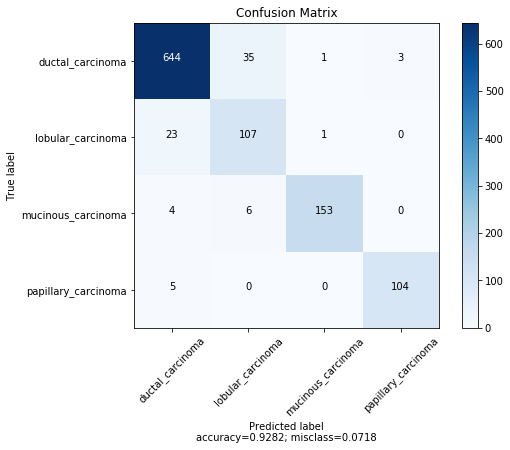

In [16]:
y_preds = threshold_arr(models[2].predict(x, verbose=0))

results = precision_recall_fscore_support(y, y_preds ,average='macro')
acc = accuracy_score(y, y_preds)

print("Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"],
                      title        = "Confusion Matrix")

In [17]:
import time
for i in range(5): 
    img = np.array(Image.open(BASE_DIR+"benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-009.png"))
    x = resize(img, SHAPE)
    x = x.reshape((1,) + x.shape) 
    start = time.time()
    prediction = models[4].predict(x, batch_size=1)
    finish = time.time()
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[0. 0. 1. 0.]]
786.9758605957031 ms
***
[[0. 0. 1. 0.]]
8.020639419555664 ms
***
[[0. 0. 1. 0.]]
8.02159309387207 ms
***
[[0. 0. 1. 0.]]
8.020162582397461 ms
***
[[0. 0. 1. 0.]]
8.022785186767578 ms
***
